## Chlorophyll-a forecasting using LSTM model



---
### Tutorial Objectives

**Objectives:**
*   Understanding how to use Deep Learning for Time-series forecasting
*   Introduction to LSTM model for chlorophyll-a forecasting
*   Analyzing the impact of various hyperparameters on the forecasting results

**Materials and Resources:**
*   Jupyter notebooks with code examples
*   Dataset
*   A good guide to LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
*   <font color='red'>(List of further readings and resources) - could we maybe include a link to a good resource explaining LSTMs and the link to Anuj's pre-print? also maybe link to published FCR data (or could put that at the end too)</font>

---

### Roadmap

In this tutorial, we will train a long short-term memory (LSTM) model to data from *Falling Creek Reservoir, Vinton, VA, USA* to predict chlorophyll-a level for 1-7 days into the future. As part of the tutorial, we explore the effects of changing various model parameters on the chlorophyll-a predictions.


Following is an overview of what to expect:

* **Section 0. Setup:** We will establish the environment and import necessary libraries to initiate the modeling process.

* **Section 1. Read Data:** We will read and visually represent the original data.

* **Section 2. Data Preprocessing:** This section will cover preprocessing the data, including scaling, splitting into training and testing sets, and creating data samples.

* **Section 3. Modeling:** Here, we will build and train the LSTM model.

* **Section 4. Evaluation and Plotting:** In this section we will evaluate the performance of the trained model using appropriate metrics and visualize the predictions against the actual values

* **Section 5. Experiment:** This section will involve conducting experiments to explore the impact of different hyperparameters on the model's prediction performance.



---


# Section 0. Setup

In this section, we load some key dependencies and functions that are needed to run the tutorial.

For simplicity, we have only *exposed* code that is critical for understanding and meeting the learning objectives. However, if at any time you would like to see code that is *hidden* from view, you can click the ``Show code`` button for a code chunk and the code will be displayed.

In [ ]:
!rm -r "/content/Eco_KGML_workshop"

rm: cannot remove '/content/Eco_KGML_workshop': No such file or directory


In [ ]:
# @title 0.1. Get resources
import sys
sys.path.insert(1, '/content/Eco_KGML_workshop/')

import os
if os.path.exists("/content/Eco_KGML_workshop"):
  print("Directory already exists.")
else:
  os.system("git clone https://github.com/sepidehfat/Eco_KGML_workshop.git")
  print("Repository cloned.")

import random
import pandas as pd
import numpy as np
from tqdm import trange
import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from utils import Utils, run_all
from encoder_decoder import seq2seq

import warnings
warnings.filterwarnings('ignore')

Repository cloned.


In [ ]:
# @title 0.2. Setup environment

'''
Check if GPU is available on the machine the notebook is running.
  If yes, then assign a GPU, else run it on CPU.
'''

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Computation device: GPU")
else:
    device = torch.device('cpu')
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under Runtime -> "
        "Change runtime type. select GPU. ")

'''
Handles variability by controlling sources of randomness
  through set seed values
'''
seed = 2024

np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Computation device: GPU


In [ ]:
# @title 0.3. Define some parameters { display-mode: "form" }
# @markdown Initialize some parameters required for learning

# Type of the Model
model_type = "LSTM"

# Output size of our encoder_decoder model, i.e. number of target variables
output_size = 1


# Number of layers in our deep learning model
num_layers = 1

# Hidden cell size
hidden_feature_size = 64

# Dropout is a form of regularization
dropout = 0.01


# While generating the training batches do we want the generator to shuffle the batches?
batch_shuffle = True

# Eval freq says how frequently during training do you want to evaluate your model on the validation data (to see its performance on non-training data)
eval_freq = 10 # logic is -> if iteration_num % eval_freq == 0 -> then perform evaluation

'''
Learning rate scheduler parameters
'''
max_lr=5e-4
div_factor=100
pct_start=0.05
anneal_strategy='cos'
final_div_factor=10000.0

'''
Parameters for early stopping
'''
# Set to True if we want Early stopping
early_stop = False

# If there is no improvement for a 'thres' number of epocs stop the training process
thres=5

# Quantifying the improvement. If the validation loss is greater than min_val_loss_so_far + delta for thres number of iterations stop the training
delta=0.5

# Specify the percentage of times we want to enforce teacher forcing
teacher_forcing_ratio = 0.0
training_prediction = 'recursive'

#define file name
file_name = 'LSTM_dataset.csv'




---


# Section 1. Read Data

Here, we will read in the dataset and define which variables we want to use as drivers (features) as well as the variable we are trying to predict (the target variable).


In [ ]:
# @title 1.1. Read the files { run: "auto", vertical-output: true, display-mode: "form" }

# Input path
path = '/content/Eco_KGML_workshop'

# Name of the data file
file_name = 'LSTM_dataset.csv'

# Name of the metadata file
'''
metadata file contains information about data columns. \
  We want to extract names of the features and target variables from the metadata DataFrame.\
  We further use them to read the main data file.
'''
metadata = 'LSTM_dataset_column_key.csv'

# Read metadata file
dx = pd.read_csv(os.path.join(path, metadata))

# Extract all col names from Metadata
feature_cols = dx[dx['column_type']=='feature']['column_names'].tolist()  # feature colums represent the input drivers
target_cols = dx[dx['column_type']=='target']['column_names'].tolist()   # target column represent the chlorophyll values
date_col = dx[dx['column_type']=='date']['column_names'].tolist()[0]    # date column stores the date timeline

# Read data
'''
The main dataset contains the actual measurements and feature values over time.
'''
df = pd.read_csv(os.path.join(path, file_name))

print("The target column is:", target_cols)
print("The feature columns are:", feature_cols)

The target column is: ['daily_median_chla_interp_ugL']
The feature columns are: ['daily_median_airtemp_interp_degC', 'daily_median_swr_interp_Wm2', 'daily_median_inflow_interp_cms', 'daily_median_watertemp_interp_degC', 'daily_median_srp_interp_ugL', 'daily_median_din_interp_ugL', 'daily_median_inflow_srp_interp_ugL', 'daily_median_inflow_din_interp_ugL', 'daily_median_Secchi_interp_m', 'daily_median_CTD_Temp_C', 'daily_median_GreenAlgae_ugL', 'daily_median_Bluegreens_ugL', 'daily_median_BrownAlgae_ugL', 'daily_median_TotalConcNoMixed_ugL']


`target_cols` is the names of the variables we aim to predict, which, in this specific problem, is Chlorophyll.

Features are the variables that equip the model with the necessary information for making predictions. Within this dataset, input features consist of various environmental factors such as air temperature, water temperature, green algae, inflow interpolation, etc.



Previously measured chlorophyll values can influence future chlorophyll levels. We can determine whether to integrate Chlorophyll data into our input feature list.

In [ ]:
# Specify whether we want to add chlorophyll to the input feature list
feature_cols += target_cols
feature_cols

['daily_median_airtemp_interp_degC',
 'daily_median_swr_interp_Wm2',
 'daily_median_inflow_interp_cms',
 'daily_median_watertemp_interp_degC',
 'daily_median_srp_interp_ugL',
 'daily_median_din_interp_ugL',
 'daily_median_inflow_srp_interp_ugL',
 'daily_median_inflow_din_interp_ugL',
 'daily_median_Secchi_interp_m',
 'daily_median_CTD_Temp_C',
 'daily_median_GreenAlgae_ugL',
 'daily_median_Bluegreens_ugL',
 'daily_median_BrownAlgae_ugL',
 'daily_median_TotalConcNoMixed_ugL',
 'daily_median_chla_interp_ugL']



---


### 1.2. Visualization of dataframe
This is the dataframe we will be using to fit our model.

In [ ]:
df

,Date,daily_median_airtemp_interp_degC,flag_daily_median_airtemp_interp_degC,daily_median_swr_interp_Wm2,flag_daily_median_swr_interp_Wm2,daily_median_inflow_interp_cms,flag_daily_median_inflow_interp_cms,daily_median_watertemp_interp_degC,flag_daily_median_watertemp_interp_degC,daily_median_srp_interp_ugL,...,daily_median_GreenAlgae_ugL,flag_daily_median_GreenAlgae_ugL,daily_median_Bluegreens_ugL,flag_daily_median_Bluegreens_ugL,daily_median_BrownAlgae_ugL,flag_daily_median_BrownAlgae_ugL,daily_median_TotalConcNoMixed_ugL,flag_daily_median_TotalConcNoMixed_ugL,daily_median_chla_interp_ugL,flag_daily_median_chla_interp_ugL
0,2018-08-01,21.690000,False,2.576500,False,0.001250,False,26.8840,True,10.0,...,3.25,True,6.9300,True,2.320,True,12.5000,True,4.010,True
1,2018-08-02,21.195000,False,1.132500,False,0.003451,False,26.8840,True,10.0,...,3.25,False,6.9300,False,2.320,False,12.5000,False,4.010,True
2,2018-08-03,20.290000,False,1.154821,True,0.005080,False,26.8840,True,10.0,...,3.25,True,6.6175,True,2.315,True,12.1825,True,4.010,True
3,2018-08-04,23.555000,False,1.177141,True,0.003196,False,26.8840,True,10.0,...,3.25,True,6.3050,True,2.310,True,11.8650,True,4.010,True
4,2018-08-05,24.730000,False,1.199462,True,0.001073,False,26.8840,True,10.0,...,3.25,True,5.9925,True,2.305,True,11.5475,True,4.010,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,2021-12-27,10.243952,False,1.002000,False,0.012620,False,6.6005,False,12.0,...,0.00,True,2.3700,True,30.080,True,32.4500,True,6.755,False
1245,2021-12-28,15.110000,False,0.699500,False,0.013166,False,6.9580,False,12.0,...,0.00,True,2.3700,True,30.080,True,32.4500,True,6.360,False
1246,2021-12-29,13.430000,False,0.354000,False,0.014107,False,7.5310,False,12.0,...,0.00,True,2.3700,True,30.080,True,32.4500,True,7.805,False
1247,2021-12-30,12.385000,False,0.000000,False,0.014107,False,7.2090,False,12.0,...,0.00,True,2.3700,True,30.080,True,32.4500,True,7.680,False




---

### 1.3. Visualization of Chlorophyll-a distribution

This plot shows the variation of daily median Chlorophyll-a concentration over time. This plot provides insights into the temporal trends and fluctuations in Chlorophyll-a concentration.

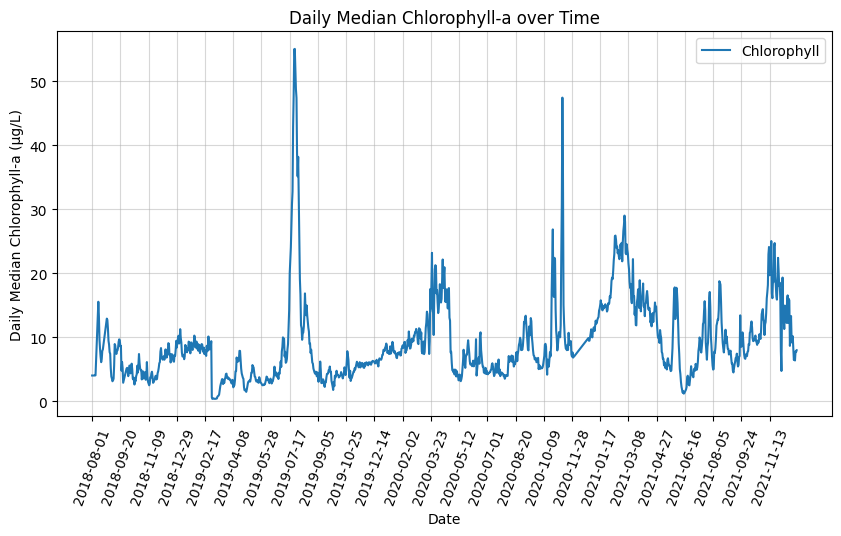

In [ ]:
# @title  { display-mode: "form" }

plt.figure(figsize=(10, 5))

plt.plot(df['Date'], df['daily_median_chla_interp_ugL'], label="Chlorophyll")
plt.xticks(df['Date'][::50], rotation=70)
plt.grid(visible=True, alpha=0.5)

# Set labels and title
plt.xlabel('Date')
plt.ylabel(u'Daily Median Chlorophyll-a (\u03bcg/L)')
plt.title('Daily Median Chlorophyll-a over Time')

plt.legend()
plt.show()



---


# Section 2. Data Preprocessing



---


### 2.1. Create a utility object
We create an object of the Utils class. It contains all the utility functions like splitting train and test data, normalizing the data, etc.

In [ ]:
'''
Utility instance - to perform data processing, train test split
'''
utils = Utils(num_features=len(feature_cols), inp_cols=feature_cols, target_cols=target_cols, date_col=date_col, num_out_features=output_size, device=device)

---

### 2.2. Train Test split
Ideally, a 3-way split is done - train, val and test.

- The **Training** set is used to teach or "train" the machine learning model. It contains the majority of the data and is where the model learns the relationships between the features and the target variable.

- The **Test** set is used to assess the performance of the model. The test set acts as new, unseen data for the model, simulating how the model will perform in real-world scenarios

- The **Validation** split is generally used to tune the hyper-parameters during training. Once the hyper-parameters are tuned, the model is re-trained on the train+val data. To keep the notebook short and simple, **hyper-parameter tuning is not included.**






---


#### Hyperparameter - split ratio
The split ratio is a hyper-parameter that refers to the division of the dataset into separate subsets for training, validation, and testing purposes. However, in this tutorial, where hyperparameter tuning is not conducted, the split ratio exclusively refers to the partitioning of data into training and testing sets. (For instance, a split ratio of 60 signifies that 60% of the data samples are allocated for training, while the remaining 40% are used for testing.)

In [ ]:
split_ratio = 0.6

'''
Split data into train and test
'''
df_train, df_test = utils.train_test_split(df, split_ratio=split_ratio)

In [ ]:
# @title  { display-mode: "form" }
# @markdown Data shape is as follows.
print("The main data set consists of {} number of data, which is splitted to {} number of train and {} number of test instances.".format(df.shape[0], df_train.shape[0], df_test.shape[0]))


The main data set consists of 1249 number of data, which is splitted to 749 number of train and 500 number of test instances.




---


### 2.3. Normalize the data
Standard normalization, also known as Z-score normalization, is a common technique used to scale features to have a mean of 0 and a standard deviation of 1. This process transforms the data distribution to have a mean of 0 and a variance of 1, making it easier to compare and analyze different features.

$$ \text{Normalized value} = \frac{{\text{Original value} - \text{Mean}}}{{\text{Standard deviation}}} $$


In [ ]:
df_train = utils.normalize(df_train)
df_test = utils.normalize(df_test, use_stat=True)



---
### 2.4. Generating data samples
<font color='red'>I like that you define these here! I do think it might be beneficial to move the definition up to the chunk where parameters are set.</font>

Each sample is a combination of a lookback window and a horizon window. The sliding window technique functions as a mechanism to generate training samples by iteratively moving across the time series data.

- **Lookback Window:** This is the size of the window that determines how many past time steps are considered as input features for predicting the future. In the context of LSTM, the network will learn patterns in the data based on the observations within this lookback window.

- **Horizon Window:** This represents the size of the window into the future that the model aims to predict. It determines how far ahead the LSTM model will forecast.

- **Sample:** Sample is a single instance or observation used for training the LSTM model. Each sample consists of the input features (observations from the lookback window) and the target output (observations from the horizon window).

- **Sliding Window:** This refers to the technique of moving a fixed-size window (or interval) across the time series data. At each step, the window slides forward by a certain number of time steps. This approach allows us to create multiple samples or training instances from the time series data.

- **Stride:** Stride refers to the number of time steps by which the sliding window moves forward during each iteration when generating samples. For example, if the stride is set to 1, the sliding window moves forward by one time step at a time, creating overlapping samples.



Putting it all together:
<p align="center">
sliding window = lookback window + horizon window = sample
</p>


<p align="center">
  <img src="https://github.com/sepidehfat/Eco_KGML_workshop/blob/main/Images/window.png?raw=true" alt="Image Title">
</p>



In [ ]:
# Lookback window
input_window = 14

# horizon window
output_window = 7

# stride - While creating samples (lookback window + horizon window = 1 sample) define the amount of stride the sliding window needs to take
stride = 1

In [ ]:
'''
Prepare data : 1 training sample = lookback window + horizon window
'''
X_train, Y_train = utils.windowed_dataset(df_train, input_window, output_window, stride)
X_test, Y_test = utils.windowed_dataset(df_test, input_window, output_window, stride)

In [ ]:
# @title  { display-mode: "form" }
# @markdown Data shape is as follows.
print("There are {} number of train samples and {} number of test samples.".format(X_train.shape[0], X_test.shape[0]))
print("Each sample consists of {} number of features, which are the input of the model.".format(X_train.shape[2]))
print("For sampling, the window size is: {}".format(X_train.shape[1]))


There are 729 number of train samples and 480 number of test samples.
Each sample consists of 15 number of features, which are the input of the model.
For sampling, the window size is: 14




---


# Section 3. Modeling

**Long Short-Term Memory (LSTM)** is a type of recurrent neural network (RNN) architecture designed to capturing long-term dependencies.


LSTM works by selectively updating and forgetting information through the gating mechanisms. The input gate allows relevant information to be added to the memory, while the forget gate filters out unnecessary information. This mechanism enables the LSTM to capture long-term dependencies in sequential data.


**The model used for time-series forecasting is an encoder-decoder model** where the encoder and decoder are simple LSTM blocks. In the code, **seq2seq (or Sequence-to-Sequence)** refers to this encoder-decoder model

- The **encoder** processes the input sequence and compresses the information into a fixed-length context vector or hidden state.
The final hidden state of the encoder contains a summarized representation of the entire input sequence, which is then passed to the decoder.

- The **decoder** consists of another LSTM network which takes the output of the encoder as an input, and generates the output sequence for forecasting window.


<p align="center">
  <img src="https://github.com/sepidehfat/Eco_KGML_workshop/blob/main/Images/enc_dec.png?raw=true" alt="Image Title">
</p>



---


#### 3.1. Hyperparameters - model training
- **Batch Size:** Number of data samples propagated through the model during a single training iteration. Larger batch sizes may lead to faster training but require more memory.

- **Epochs:** Number of times the entire training dataset is passed through the model.

- **Learning Rate:** Rate at which the model parameters are updated during training. It influences the speed and direction of learning, with larger learning rates leading to faster convergence but possibly overshooting optimal solutions.

- **Weight Decay:** A regularization technique that penalizes large weights in the model to prevent overfitting. By penalizing large weights, weight decay encourages the model to learn simpler patterns in the data, leading to improved generalization performance on unseen data.



In [ ]:
'''
Model Training parameters
'''
# batch_size during training
batch_size = 32

# Number of epochs we want to train the model for (1 epoch = 1 pass of the complete training data through the model)
epochs = 100

# Learning rate specifies the rate at which we want to update the model parameters after every training pass
learning_rate = 0.0001


'''
Regularization parameters
'''
# Specify the amount of L2 regularization to be applied.
weight_decay=0.05

In [ ]:
# @title Define config file { display-mode: "form" }
config = {
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "eval_freq": eval_freq,
    "batch_shuffle": batch_shuffle,
    "dropout":dropout,
    "num_layers": num_layers,
    "hidden_feature_size": hidden_feature_size,
    "model_type": model_type,
    "teacher_forcing_ratio": teacher_forcing_ratio,
    "max_lr": max_lr,
    "div_factor": div_factor,
    "pct_start": pct_start,
    "anneal_strategy": anneal_strategy,
    "final_div_factor": final_div_factor,
    "dataset": file_name,
    "split_ratio":split_ratio,
    "input_window":input_window,
    "output_window":output_window,
    "early_stop_thres":thres,
    "early_stop_delta":delta,
    "early_stop":early_stop,
    "weight_decay":weight_decay
}



---


### 3.2. Define the model
<!--
<div align="center">
  <div style="background-color: white;">
    <img src="https://github.com/sepidehfat/Eco_KGML_workshop/blob/main/LSTM.png?raw=true" alt="Image Title">
  </div>
</div> -->

<!-- https://colah.github.io/posts/2015-08-Understanding-LSTMs/ -->



In [ ]:
'''
Create the seq2seq model
'''
model = seq2seq(input_size = X_train.shape[2],
                hidden_size = hidden_feature_size,
                output_size = output_size,
                model_type = model_type,
                num_layers = num_layers,
                utils = utils,
                dropout = dropout,
                device = device
               )



---


### 3.3. Train the model


In [ ]:
'''
Train the model
'''
loss, test_rmse, train_rmse = model.train_model(X_train,
                                              Y_train,
                                              X_test,
                                              Y_test,
                                              target_len = output_window,
                                              config = config,
                                              training_prediction = training_prediction
                                              )

100%|██████████| 100/100 [00:23<00:00,  4.19it/s, loss=0.302, test_rmse=4.89, train_rmse=3.4]




---

### 3.4. Plot train-test RMSE

**Root Mean Squared Error (RMSE)** is a widely used metric for evaluating the performance of the models. It measures the average deviation of predicted values from the actual values in a dataset.

RMSE is calculated by taking the square root of the average of the squared differences between the predicted values and the actual values. Mathematically, it is represented as:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where \( n \) is the number of samples in the dataset, $( y_i )$ is the actual value of the target variable for the $( i^{th} )$ sample, and $( \hat{y}_i)$ is the predicted value of the target variable for the $( i^{th} )$ sample.






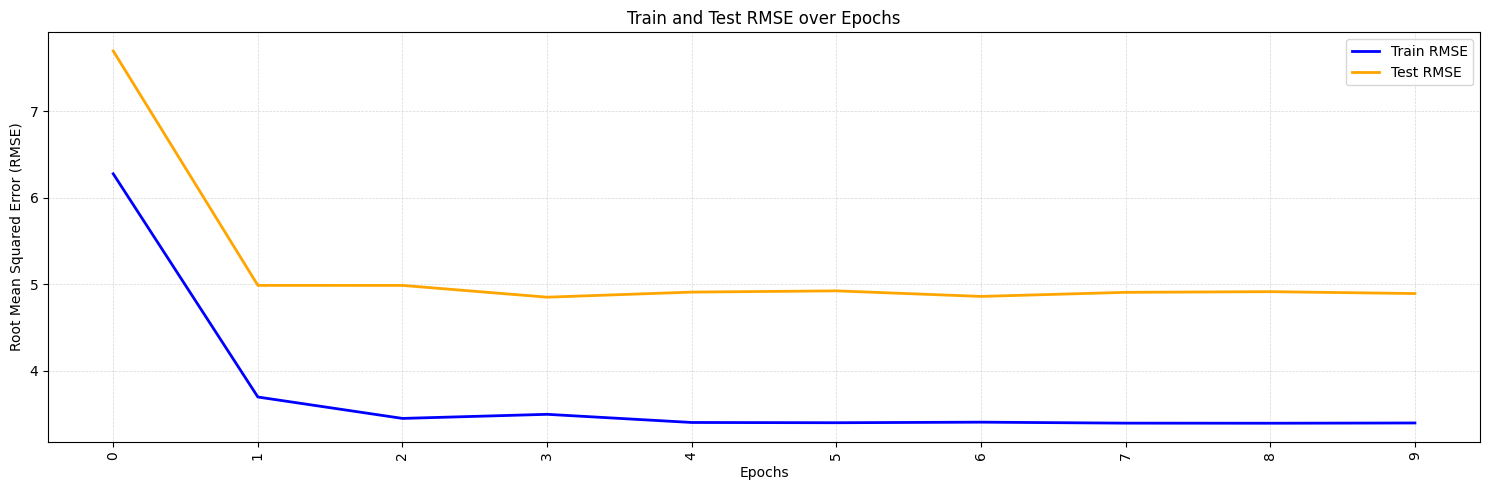

In [ ]:
# @title  { display-mode: "form" }
utils.plot_RMSE_epochs(test_rmse, train_rmse)



---



### 3.5. Save the model

<!-- You can save the model weights to have it as a refrence. By saving the weights, you preserve the learned parameters, enabling you to reload the model in its trained state. This can be particularly useful for tasks where training the model is time-consuming or resource-intensive. -->
We can save the model to re-use it later. Training the model is a resource-intensive and time-consuming task. Hence, saving the model reduces the need to re-train later. We can directly load the model and apply it for forecasting.

In [ ]:
MODEL_PATH_SAVE = "./current_model_weights"
torch.save(model.state_dict(), MODEL_PATH_SAVE)



---


# Section 4. Evaluation and Plotting




### 4.1. Load the model for evaluation

<!--

By setting `load_current` to true, you would use the weights of the model that you have already trained. This option is beneficial when you want to continue training from a specific checkpoint or fine-tune the model on your own dataset
 -->


If we set `load_pretrained` to true, we would use an already trained model (not the one we just trained above) for the evaluation purpose. This previous model has been trained with the same set of parameters (default) in this notebook, but for a larger number of epochs (500).

In [ ]:
# paths to load the model
MODEL_PATH_PRETRAINED = "./Eco_KGML_workshop/pretrained_model_weights"
MODEL_PATH_CURRENT = "./current_model_weights"

load_pretrained = False

if load_pretrained:
    model.load_state_dict(torch.load(MODEL_PATH_PRETRAINED))
    print("The model is loaded from github.")
else:
    model.load_state_dict(torch.load(MODEL_PATH_CURRENT))
    print("Loaded the model we currently trained.")

Loaded the model we currently trained.




---


### 4.2. Evaluation


`evaluate_batch` evaluates the performance of the model on the train and test dataset. It computes predictions and calculates the Root Mean Squared Error (RMSE) between the predicted and true values, and returns a dictionary containing the predictions, true values, and RMSE.

In [ ]:
'''
Perform evaluation
'''
train_eval_metrics = model.evaluate_batch(X_train.to(device), Y_train.to(device))
test_eval_metrics  = model.evaluate_batch(X_test.to(device), Y_test.to(device))



---


### 4.3. Visualizations of evaluation

Here we can see the plots of the predicted values for multiple horizon windows (specified by T) alongside the ground-truth values. We can see the model's predictions over time, and comparing them to the actual observed values. The x-axis represents the timeline, and the y-axis represents the predicted chlorophyll values at different time steps. <br>
We can specify the forecast horizon range, i.e. whether we want to visualize T+1 day ahead predictions, or T+5 day ahead predictions, etc. The maximum step is the size of the output window used to train the model

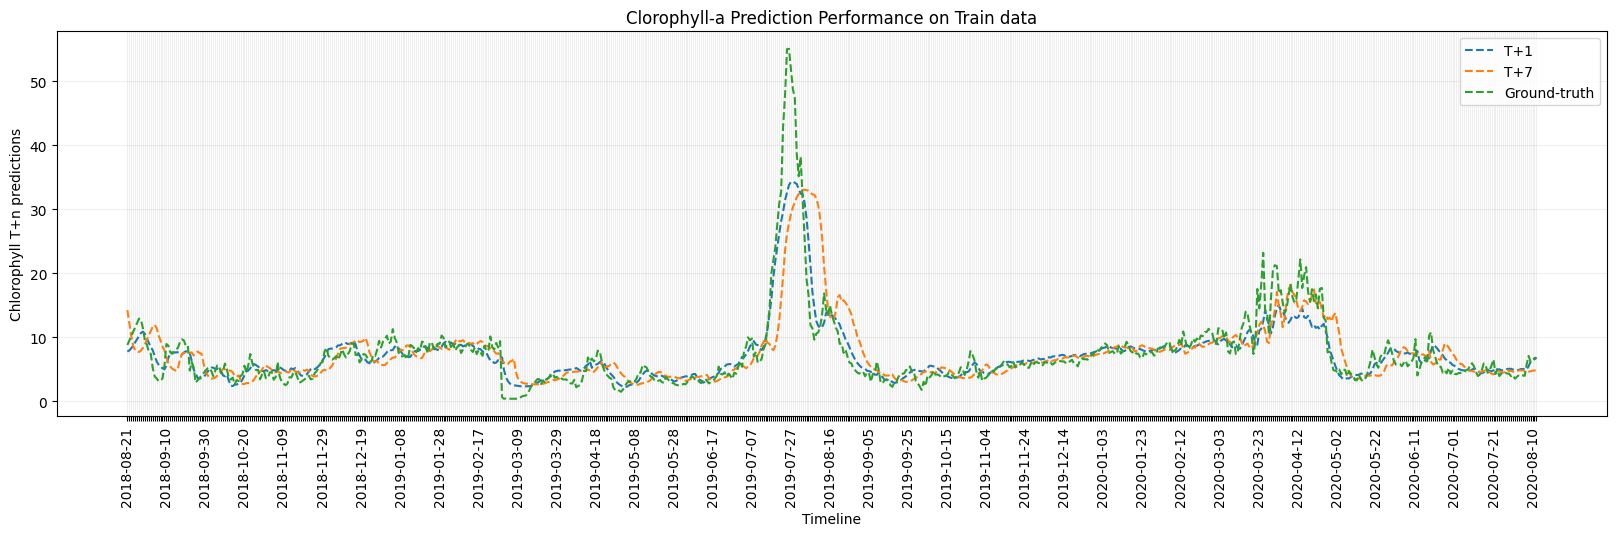

In [ ]:
'''
Generate the plots on train data
'''

# Specify the list of T+n predictions to plot
horizon_range = [1, 7] # this will plot T+1 and T+n predictions w.r.t Ground truth

utils.plot_predictions(df_train, train_eval_metrics, horizon_range, split='Train')

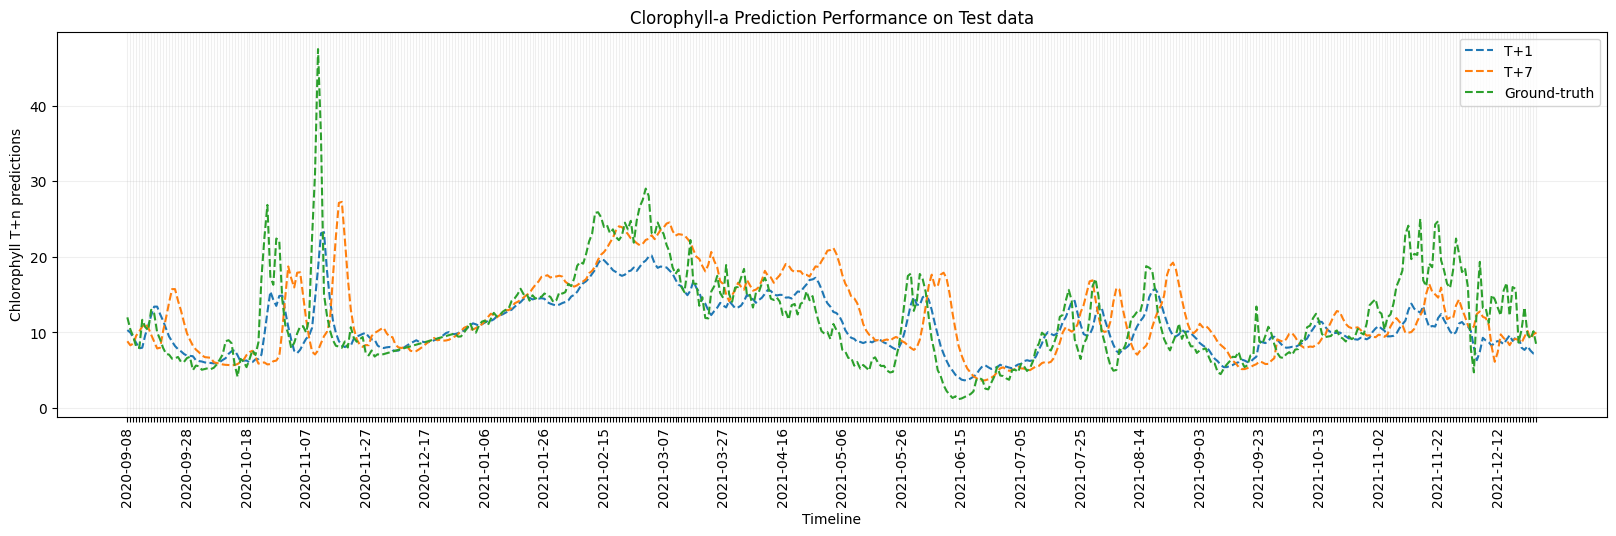

In [ ]:
'''
Generate the plots on test data
'''

# Specify the list of T+n predictions to plot
horizon_range = [1, 7] # this will plot T+1 and T+n predictions w.r.t Ground truth

utils.plot_predictions(df_test, test_eval_metrics, horizon_range, split='Test')



---


### 4.5. Plot RMSE across different horizons

In this part, Root Mean Squared Error (RMSE) for each horizon window (T) is calculated. Then we plot the RMSE values for both the training and testing datasets across different horizon windows.

The x-axis represents the horizon window (T+n), and the y-axis represents the RMSE values.

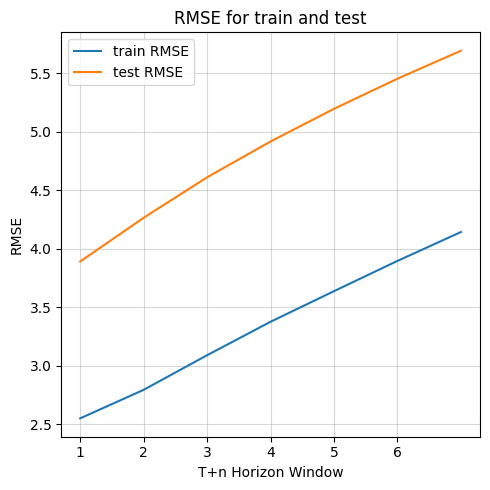

In [ ]:
train_rmse_values = utils.calculate_RMSE_horizon(df_train, train_eval_metrics)
test_rmse_values = utils.calculate_RMSE_horizon(df_test, test_eval_metrics)
utils.plot_RMSE_horizon(train_rmse_values, test_rmse_values, output_window)



---


# Section 5. Playground/Experiment



### 5.1. Playground

This section is designed to be a playground section where we can play around some of the primary parameters and observe how the model performance changes.

In machine learning, the term "experiment" can refer to modeling experiments, where models are run with different configurations and the results are compared. Here, we develop a simple experiment to test the effect of altering the lookback window and forecast horizon on model performance.

Feel free to modify these hyperparameters in `param` variable and retrain the model accordingly by calling `run_all` function. You can then compare the results with those obtained from our primary experiments.

NOTE: Please make sure you have run the cells under `"Section 0:Setup"`

Suggested experiments:

- weight_decay=0 (This can lead to overfitting on the train data)
- epoch=2 (Less training would lead to poor forecasts)
- output window=14, 21 (Increasing forecast window would show gradual decrease in the performance)

In [ ]:
'''
We can try changing one parameter value at a time and see what effect it has
'''
params = {
    'epochs': 100,
    'input_window': 14,
    'output_window': 7,
    'weight_decay': 0.05,
    'split_ratio': 0.8
}

Performing train-test split ...DONE

Normalizing the data ...DONE

Creating windows ...DONE

Training the model ...

100%|██████████| 100/100 [00:28<00:00,  3.48it/s, loss=0.306, test_rmse=3.79, train_rmse=3.73]


DONE



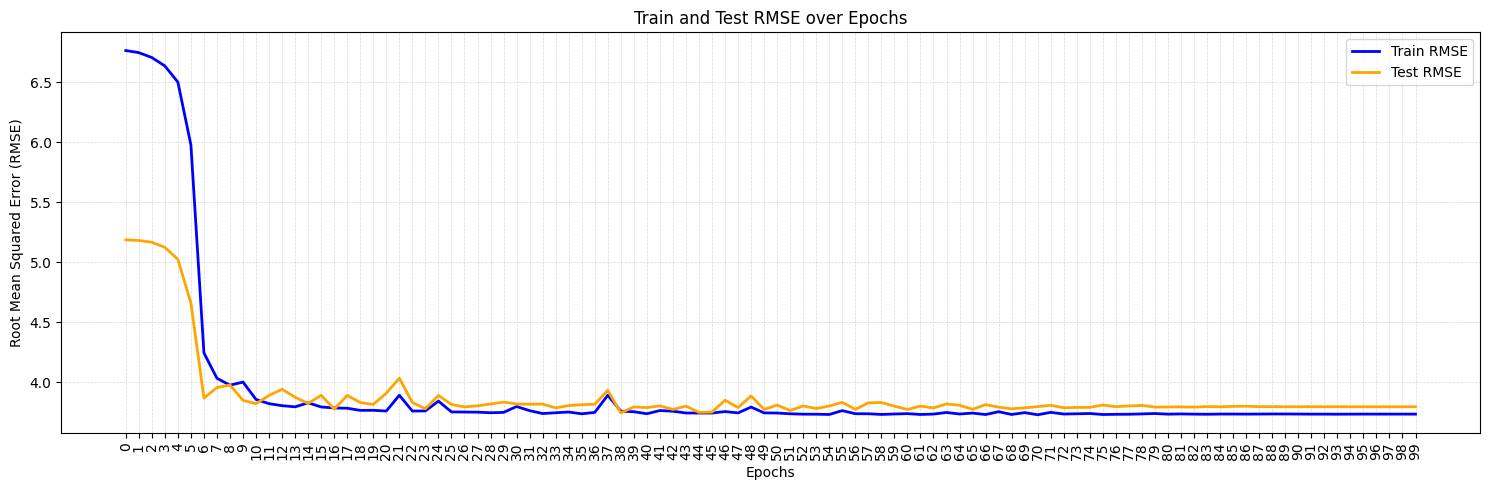

Visualizing the predictions on train data ...



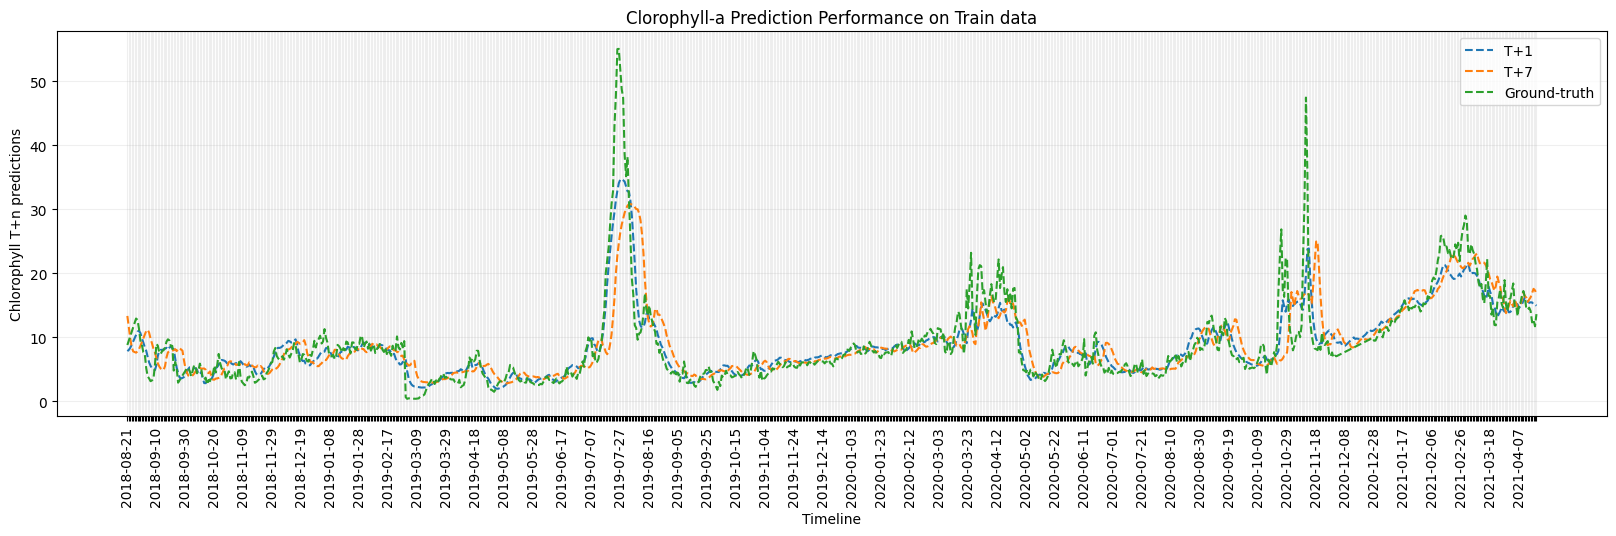

Visualizing the predictions on test data ...



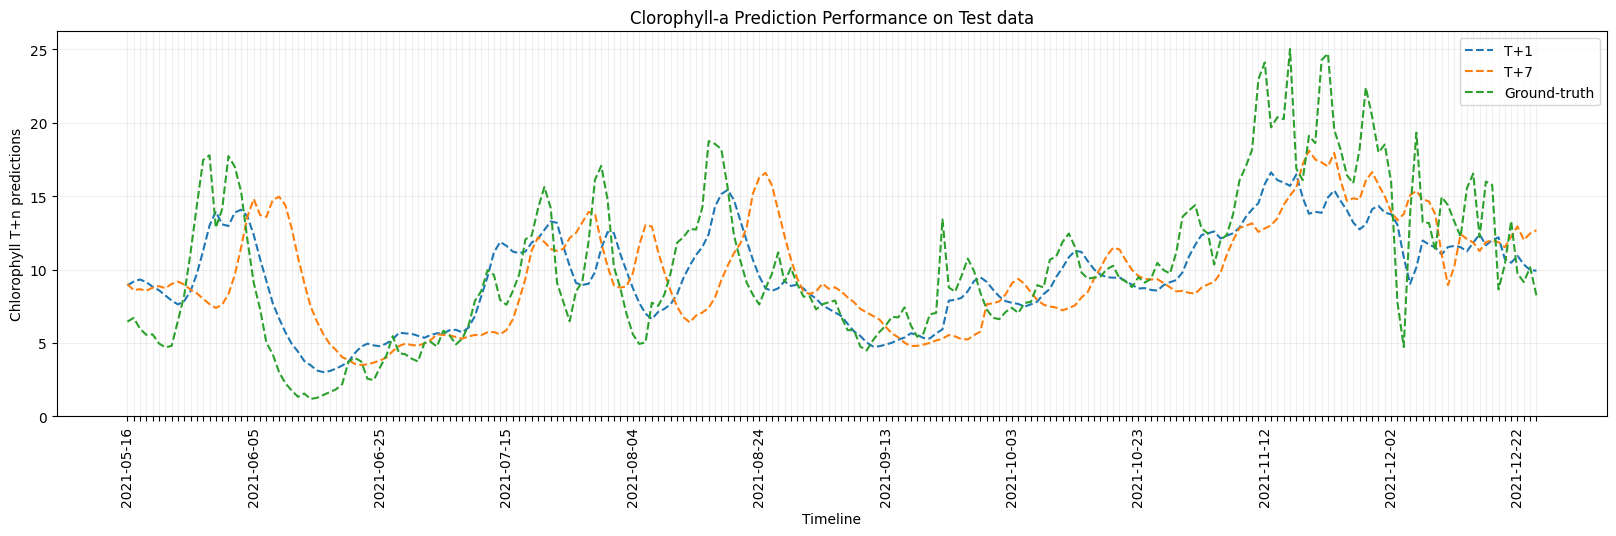

Visualizing the change in RMSE across increasing horizon window ...



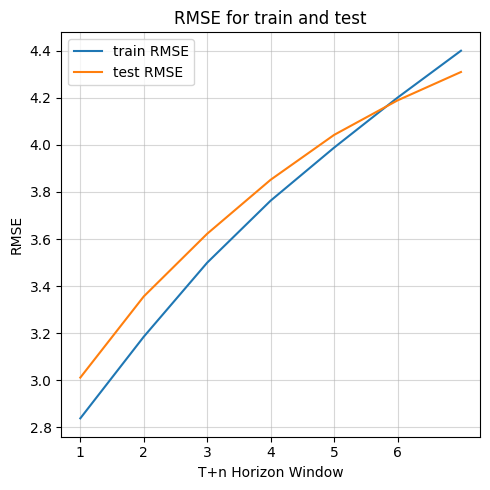

In [ ]:
'''
Specify the horizon range to plot
'''
horizon_range=[1, 7]

'''
Run and generate predictions
'''
run_all(params)



---



### 5.2. Optional Hands-on


**Overfitiing:**

Overfitting occurs when a machine learning model learns to capture noise or random fluctuations in the training data instead of learning the underlying patterns. This leads to a model that performs well on the training data but poorly on unseen data, as it has essentially memorized the training examples rather than learning generalizable patterns.

- **Size of training set:** overfitting tends to occur more frequently when the training dataset is small relative to the complexity of the model. With a small training dataset, the model may have limited exposure to the true underlying patterns and may instead learn to fit the noise present in the data.

- **Model complexity:** Regularization methods like weight decay aid in preventing overfitting by penalizing excessive parameter values in the model, limiting the model's complexity. By removing this regularization term, the model gains flexibility, which may lead to an increased risk of overfitting to the training data.

Now, you can try to adjust the hyper parammeters to induce overfitting in the model.

    'epochs': 100,
    'input_window': 14,
    'output_window': 7,
    'weight_decay': 0,
    'split_ratio': 0.4

In [ ]:
############################
## ToDo
raise NotImplementedError("Exercise: define parameters and comment/delete this line.")
############################
params = {
    'epochs': ...,
    'input_window': 14,
    'output_window': 7,
    'weight_decay': ...,
    'split_ratio': ...
}

'''
Specify the horizon range to plot
'''
horizon_range=[1, 7]

'''
Run and generate predictions
'''
run_all(params)

NotImplementedError: Exercise: define parameters and comment/delete this line.

These are observations towards the presence of overfitting in the model:

1. Perfect prediction on training data: Initially, the model demonstrates flawless prediction accuracy on the training dataset. This suggests that the model has effectively memorized the training examples.

2. Poor performance on test data: Despite the model's excellent performance on the training data, its effectiveness reduces significantly when applied to unseen test data. This indicates that the model struggles to generalize beyond the training dataset, highlighting the presence of overfitting.

3. Rise in RMSE of test data over epochs: As training progresses, the Root Mean Square Error (RMSE) of the test dataset begins to rise after reaching a certain threshold of epochs. This upward trend indicates overfitting.



---

# Feedback Survey

We value your input! Your feedback helps us improve our materials and better meet your needs. Please click the button below to provide your feedback:

<a href=""><img src="https://github.com/sepidehfat/Eco_KGML_workshop/blob/main/Images/Feedback.png?raw=true" alt="button link to survey" style="width:410px"></a>

Thank you for your participation!
